Importing necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import cv2
import random
import sklearn
import tensorflow as tf 
from tensorflow import keras
import os


/home/inlab/.local/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Storing paths of all images in a list

In [2]:
path_df = []
for dirname, _, filenames in os.walk('COVID-19_Radiography_Dataset'):
    for filename in filenames:
        if('images' in dirname):
            path_df.append(os.path.join(dirname, filename))
random.shuffle(path_df)

Visualization of X-Ray Images of each class

X-Ray Images of Class COVID :-


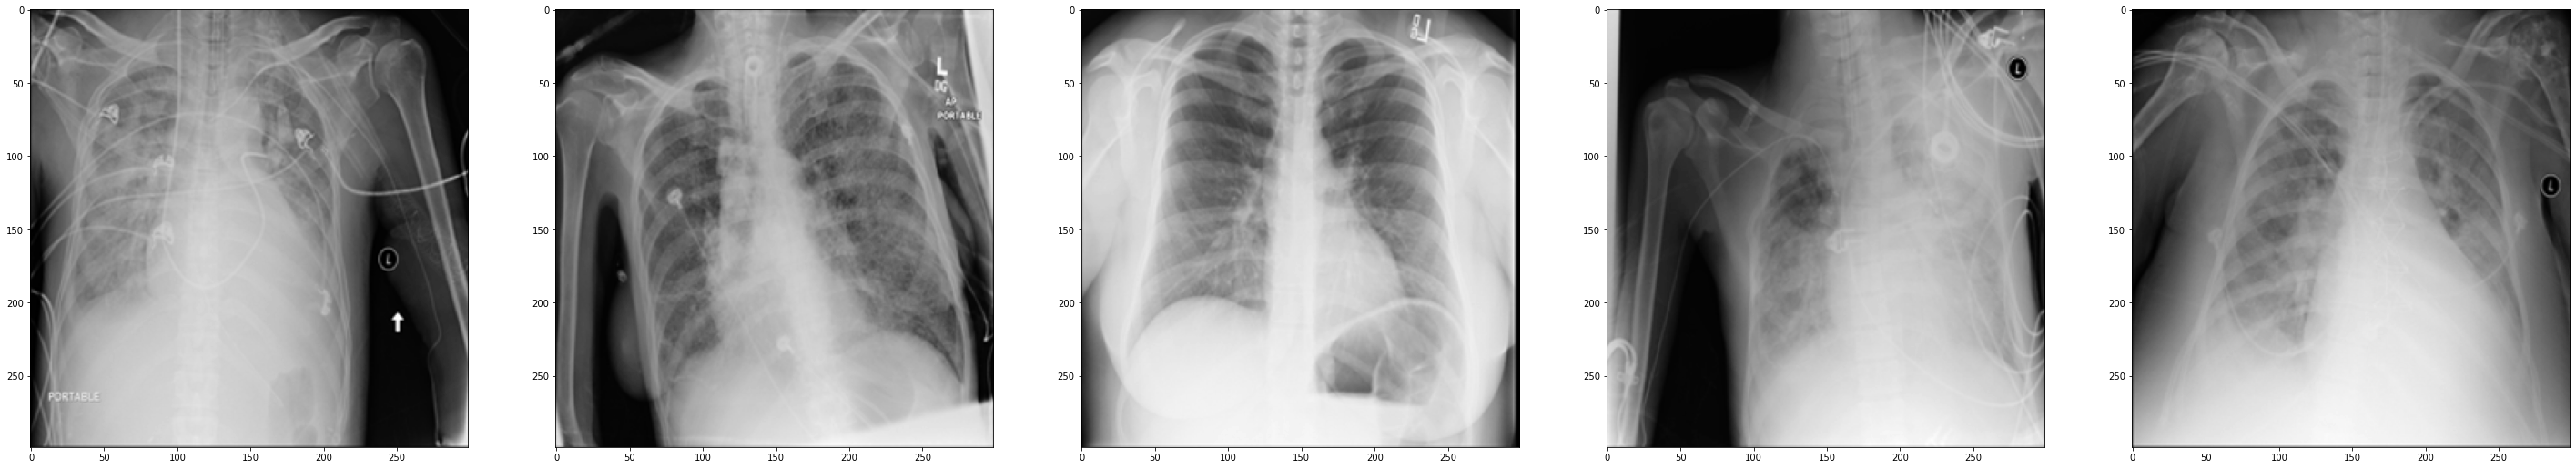

X-Ray Images of Class Lung_Opacity :-


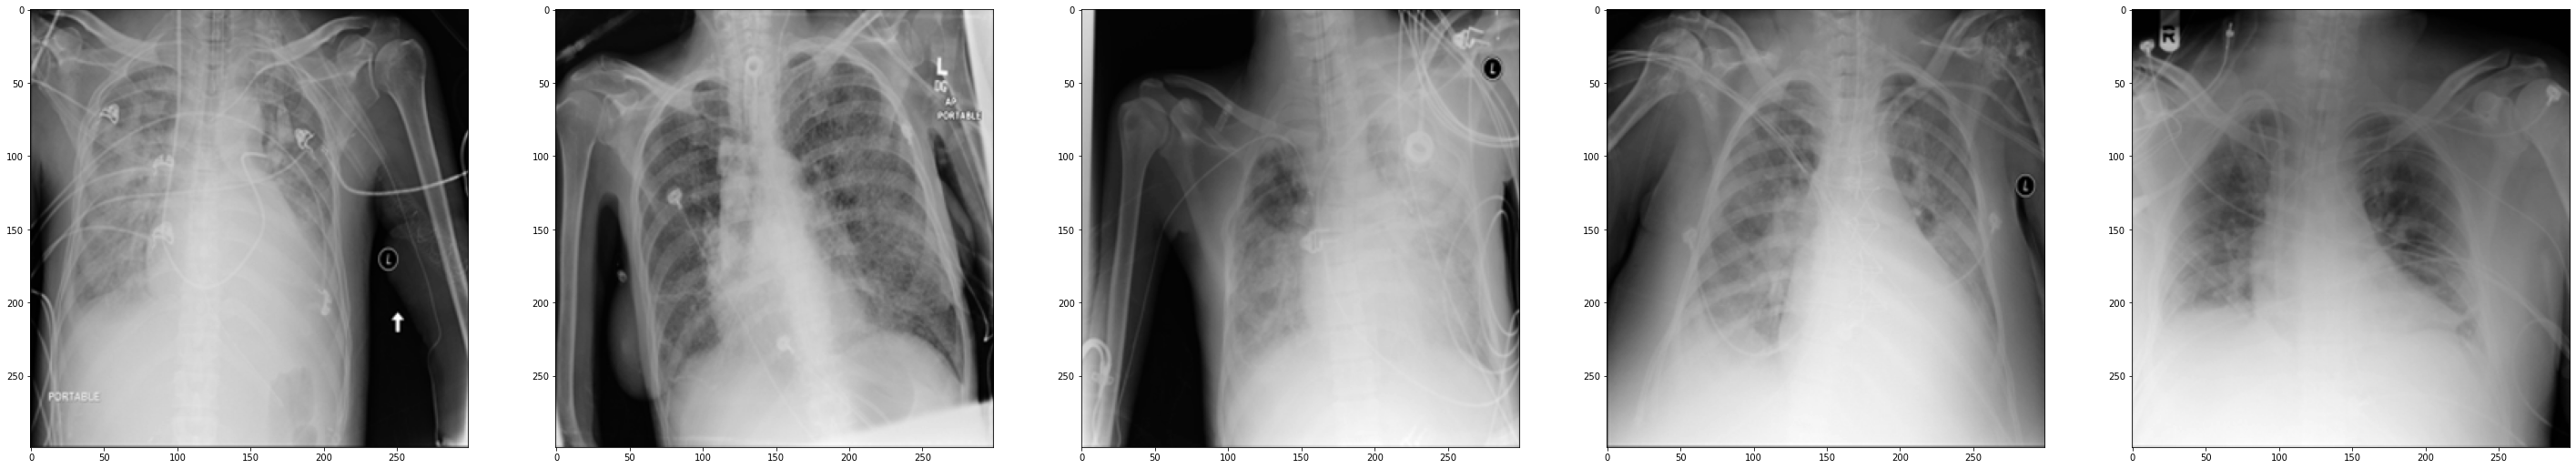

X-Ray Images of Class Normal :-


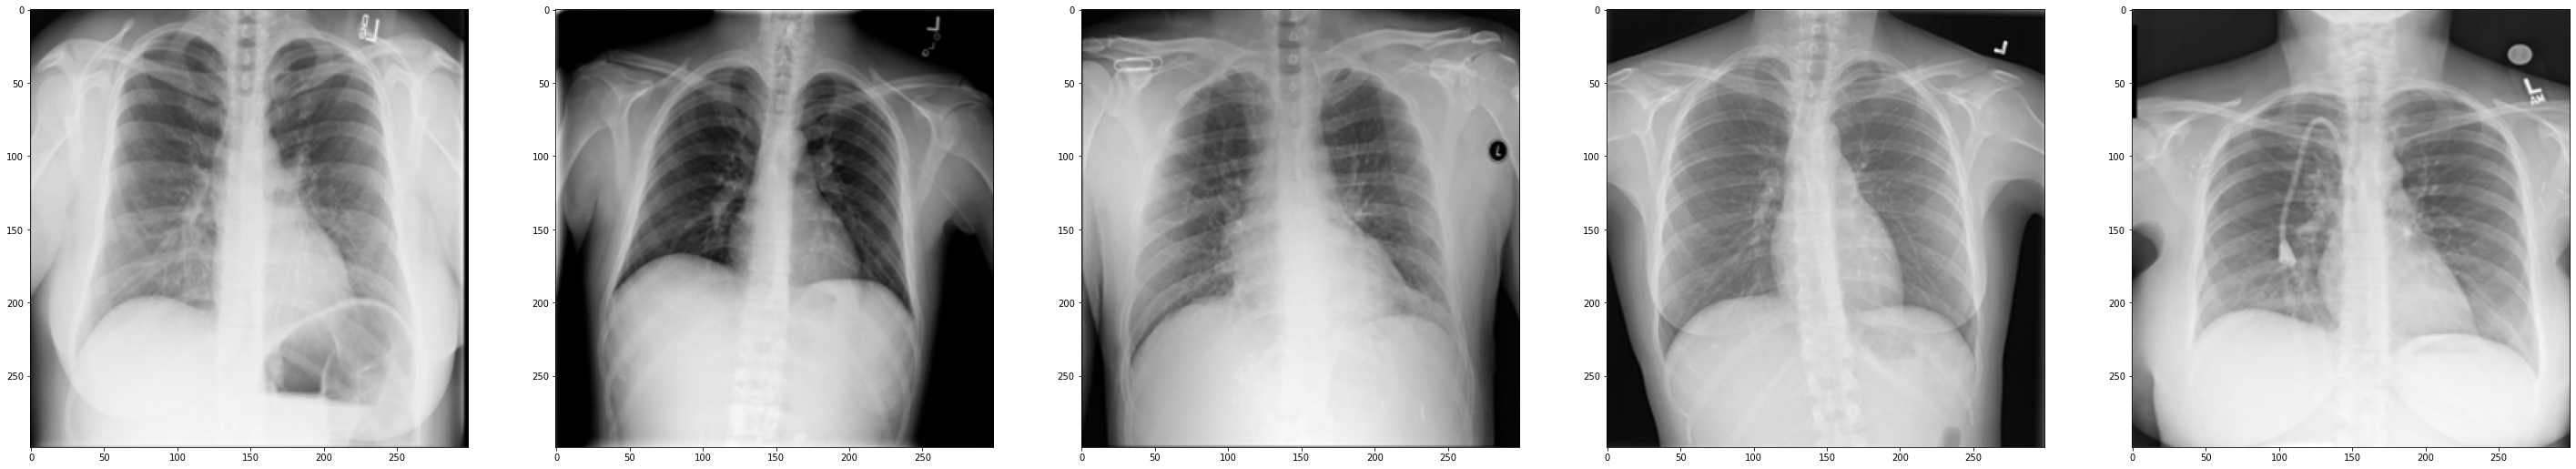

X-Ray Images of Class Viral Pneumonia :-


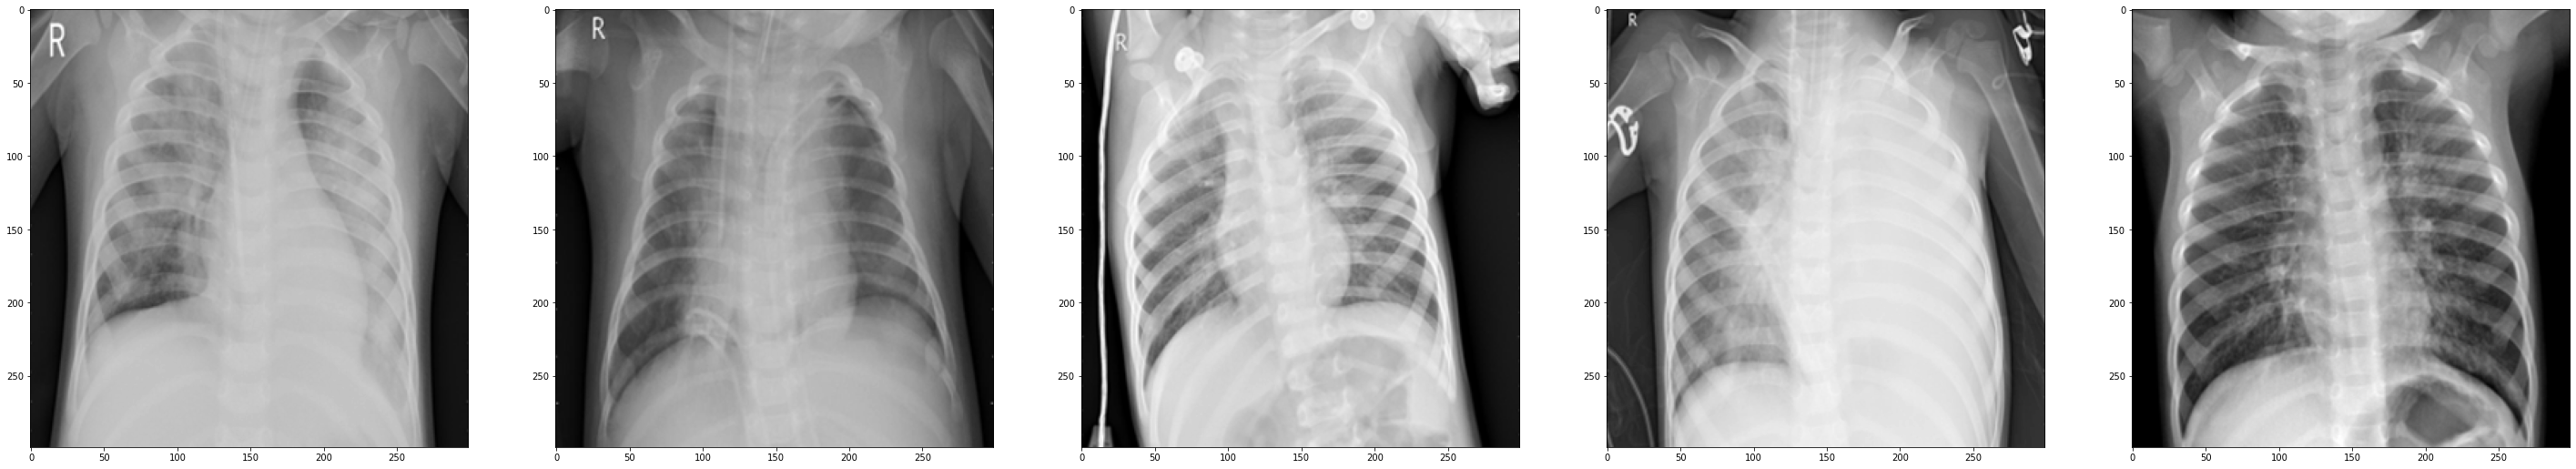

In [3]:
labels = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
for i in range(4):
    fig, axs = plt.subplots(1,5, figsize = (50,10))
    print('X-Ray Images of Class',labels[i],':-')
    paths = [k for k in path_df if(labels[i] in k)]
    for j in range(5):
        img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(paths[j], color_mode = 'grayscale'))
        axs[j].imshow(img, cmap='gray')
    plt.show()

Function to remove extra zero padding

In [4]:
def remove_zero_pad(image):
    dummy = np.argwhere(image != 0) 
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()
    crop_image = image[min_y:max_y, min_x:max_x]

    return crop_image

Loading images into training, validation and testing sets

Training Set

In [5]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []
for i in path_df[0:int(len(path_df)*0.7)]:
    img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(i, color_mode = 'grayscale'))
    crop_img = remove_zero_pad(img)
    img = tf.image.resize(crop_img, (175, 175))
    X_train.append(np.array(img/255.0, dtype = np.float16))
    y_train.append(i.split('/')[-3])

Validation Set

In [6]:
for i in path_df[int(len(path_df)*0.8):int(len(path_df))+1]:
    img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(i, color_mode = 'grayscale'))
    crop_img = remove_zero_pad(img)
    img = tf.image.resize(crop_img, (175, 175))    
    X_val.append(np.array(img/255.0, dtype = np.float16))
    y_val.append(i.split('/')[-3])

Test Set

In [7]:
for i in path_df[int(len(path_df)*0.8):int(len(path_df))+1]:
    img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(i, color_mode='grayscale'))
    crop_img = remove_zero_pad(img)
    img = tf.image.resize(crop_img, (175, 175))
    X_test.append(np.array(img/255.0, dtype = np.float16))
    y_test.append(i.split('/')[-3])

Number of Images in Each Set

In [8]:
print('Training images count:', len(y_train))
print('Validation images count:', len(y_val))
print('Testing images count:', len(y_test))

Training images count: 8053
Validation images count: 2301
Testing images count: 2301


Class Distribution of whole Dataset

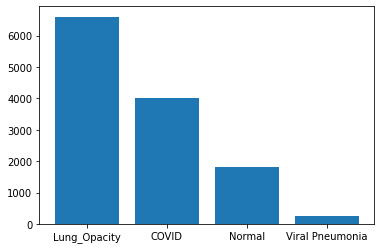

In [9]:
value_count_df = pd.DataFrame(pd.Series(np.concatenate([y_train, y_val, y_test])).value_counts()).rename_axis('unique_values').reset_index()
value_count_df.columns = ['Class', 'Count']
plt.bar(value_count_df['Class'],value_count_df['Count'])
plt.show()

Encoding Labels

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)
y_test = encoder.fit_transform(y_test)


In [11]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

ResNet Architecture

In [12]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="selu", **kwargs):   
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)                     #using "selu" activation function
        self.main_layers = [                                                    #defining main layers
            keras.layers.Conv2D(filters, 3, strides=strides,padding="same"),    #Adding convolution layers
            keras.layers.BatchNormalization(),                                  #Adding normalization layer
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,padding="same"),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: 
            self.skip_layers = [                                                #defining skip layer
                keras.layers.Conv2D(filters, 1, strides=strides,padding="same"),
                keras.layers.BatchNormalization()]
        
    def call(self, inputs):                                                     #call function
        Z = inputs
        for layer in self.main_layers:    
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)                                      #activation function on skip layer

ResNet Model

In [13]:
def ResNet_CNNModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(512, 7, strides=2, input_shape=np.shape(X_train[0]), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("selu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(128, 3, strides=1, padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("selu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same"))

    prev_filters = 128 
    for filters in [128]*2 + [64]*2:                    #Adding Residual Unit
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=2))
        prev_filters = filters

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128,activation = 'selu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(64,activation = 'selu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(4, activation="softmax"))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(), metrics=['accuracy'])         #"Adam" optimizer is used
    
    return model

In [14]:
ResNetmodel = ResNet_CNNModel()
print('Summary of ResNet CNN Model:-')
ResNetmodel.summary()

Summary of ResNet CNN Model:-
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 512)       25600     
                                                                 
 batch_normalization (BatchN  (None, 88, 88, 512)      2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 88, 88, 512)       0         
                                                                 
 dropout (Dropout)           (None, 88, 88, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 128)       589952    
                                                                 
 batch_normalization_1 (Batc  (None, 88, 88, 128)      512       
 hNormalization)          

Training of ResNetModel and saving model_weights at each epoch

In [15]:
checkpoint_path_resnet = 'training_1/resnet.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path_resnet)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_resnet,                          #callback for saving models at each epoch
                                                save_weights_only=True,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                save_best_only=True,
                                                verbose=1)

ResNetmodel_hist = ResNetmodel.fit(X_train, y_train, epochs = 30, batch_size = 25, validation_data = (X_val, y_val), callbacks = [cp_callback])

Epoch 1/30
323/323 [==============================] - ETA: 0s - loss: 1.3803 - accuracy: 0.5785
Epoch 1: val_accuracy improved from -inf to 0.59496, saving model to training_1/resnet.ckpt
323/323 [==============================] - 1015s 3s/step - loss: 1.3803 - accuracy: 0.5785 - val_loss: 1.4317 - val_accuracy: 0.5950
Epoch 2/30
323/323 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.6732
Epoch 2: val_accuracy improved from 0.59496 to 0.74707, saving model to training_1/resnet.ckpt
323/323 [==============================] - 1013s 3s/step - loss: 0.8464 - accuracy: 0.6732 - val_loss: 0.6888 - val_accuracy: 0.7471
Epoch 3/30
323/323 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.7367
Epoch 3: val_accuracy improved from 0.74707 to 0.76532, saving model to training_1/resnet.ckpt
323/323 [==============================] - 1013s 3s/step - loss: 0.6643 - accuracy: 0.7367 - val_loss: 0.6332 - val_accuracy: 0.7653
Epoch 4/30
323/323 [===========

Epoch 29/30
323/323 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9565
Epoch 29: val_accuracy did not improve from 0.88396
323/323 [==============================] - 1025s 3s/step - loss: 0.1252 - accuracy: 0.9565 - val_loss: 1.2689 - val_accuracy: 0.7353
Epoch 30/30
323/323 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9616
Epoch 30: val_accuracy improved from 0.88396 to 0.90048, saving model to training_1/resnet.ckpt
323/323 [==============================] - 1031s 3s/step - loss: 0.1026 - accuracy: 0.9616 - val_loss: 0.3719 - val_accuracy: 0.9005


Graphs of Accuracy, Val_Accuracy and Loss, Val_Loss

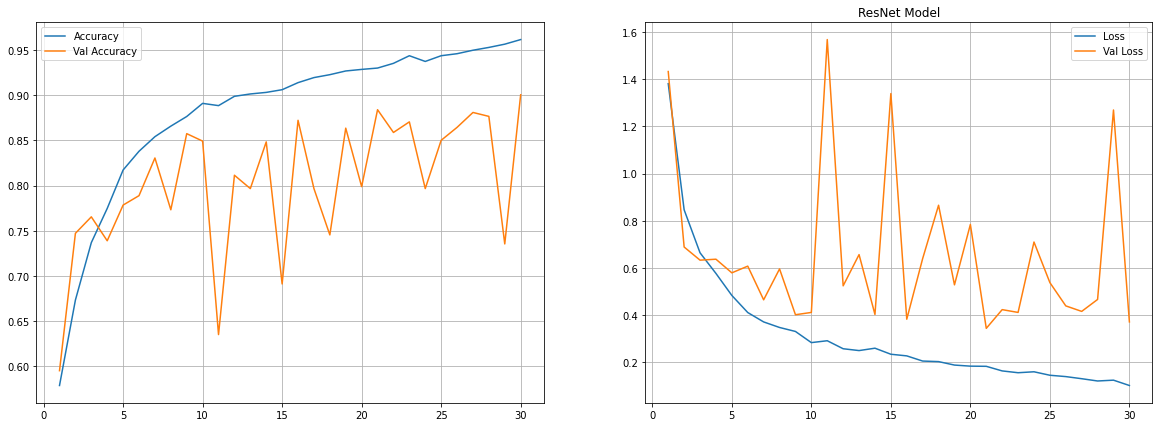

In [16]:
fig, axs = plt.subplots(1,2, figsize = (20,7))
plt.title("ResNet Model")
axs[0].plot(np.arange(1,31,1), ResNetmodel_hist.history['accuracy'], label = 'Accuracy')
axs[0].plot(np.arange(1,31,1), ResNetmodel_hist.history['val_accuracy'], label = 'Val Accuracy')
axs[0].legend()
axs[0].grid()

axs[1].plot(np.arange(1,31,1), ResNetmodel_hist.history['loss'], label = 'Loss')
axs[1].plot(np.arange(1,31,1), ResNetmodel_hist.history['val_loss'], label = 'Val Loss')
axs[1].legend()
axs[1].grid()

plt.show()


Predictions

In [17]:
prob_pred_ResNet = ResNetmodel.predict(X_test)
y_pred_ResNet = np.argmax(prob_pred_ResNet, axis=1)

72/72 [==============================] - 54s 741ms/step


Accuracy on Test Set

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

print('Accuracy on Test Set:',accuracy_score(y_test, y_pred_ResNet))
print('Classification Report:-')
print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_ResNet)))

Accuracy on Test Set: 0.9004780530204259
Classification Report:-
                 precision    recall  f1-score   support

          COVID       0.94      0.94      0.94       720
   Lung_Opacity       0.92      0.92      0.92      1202
         Normal       0.75      0.78      0.76       328
Viral Pneumonia       0.97      0.71      0.82        51

       accuracy                           0.90      2301
      macro avg       0.89      0.84      0.86      2301
   weighted avg       0.90      0.90      0.90      2301



In [21]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

def ROC_Curve(y_test, prob_pred):
    binarizer = LabelBinarizer()
    y_test_bin = binarizer.fit_transform(y=y_test)

    y_score = prob_pred

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(4):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


    # Finally average it and compute AUC
    mean_tpr /= 4  

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(14,12))

    for i in range(4):
        plt.plot(fpr[i],tpr[i],label="ROC curve of class {0} (area = {1:0.2f})".format(encoder.inverse_transform([i])[0], roc_auc[i]))

    plt.plot(fpr["micro"],tpr["micro"],label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),linestyle="--",)

    plt.plot(fpr["macro"],tpr["macro"],label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),linestyle="--",)

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

Classwise ROC Curve for ResNet Model :-


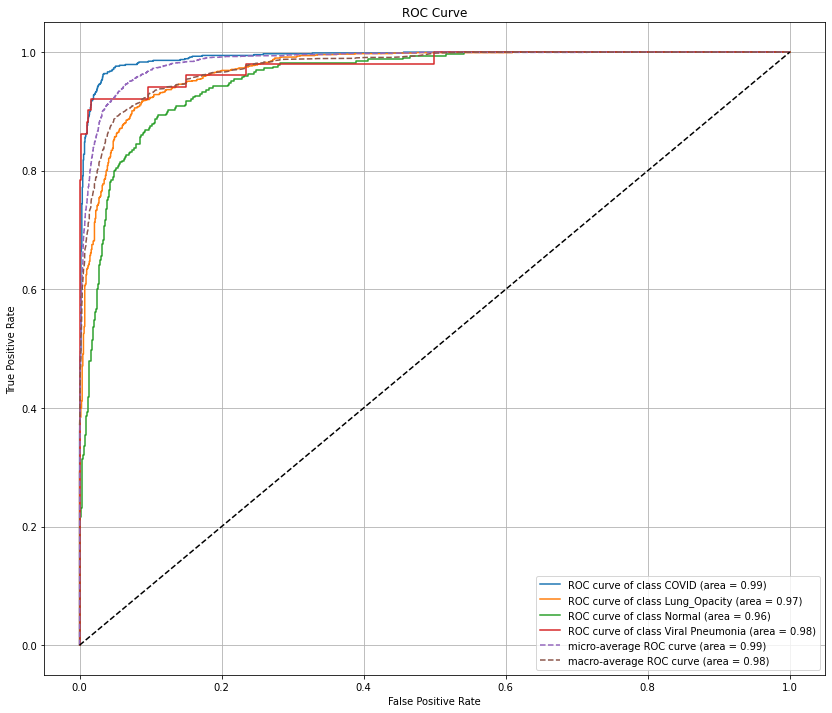

In [22]:
print("Classwise ROC Curve for ResNet Model :-")
ROC_Curve(y_test, prob_pred_ResNet)

In [23]:
# Loading model weights from checkpoint and re-evaluate
# Accuracy and Classification Report on Test Set with new model loaded with weights from checkpoint.

ResNetModel_New = ResNet_CNNModel()
ResNetModel_New.load_weights(checkpoint_path_resnet)

new_prob_pred_resnet = ResNetModel_New.predict(X_test)
y_pred_new = np.argmax(new_prob_pred_resnet, axis=1)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_new))
print('Classification Report:-')
print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred_new)))

72/72 [==============================] - 50s 690ms/step
Accuracy on Test Set: 0.9004780530204259
Classification Report:-
                 precision    recall  f1-score   support

          COVID       0.94      0.94      0.94       720
   Lung_Opacity       0.92      0.92      0.92      1202
         Normal       0.75      0.78      0.76       328
Viral Pneumonia       0.97      0.71      0.82        51

       accuracy                           0.90      2301
      macro avg       0.89      0.84      0.86      2301
   weighted avg       0.90      0.90      0.90      2301



Classwise ROC Curve for ResNet Model :-


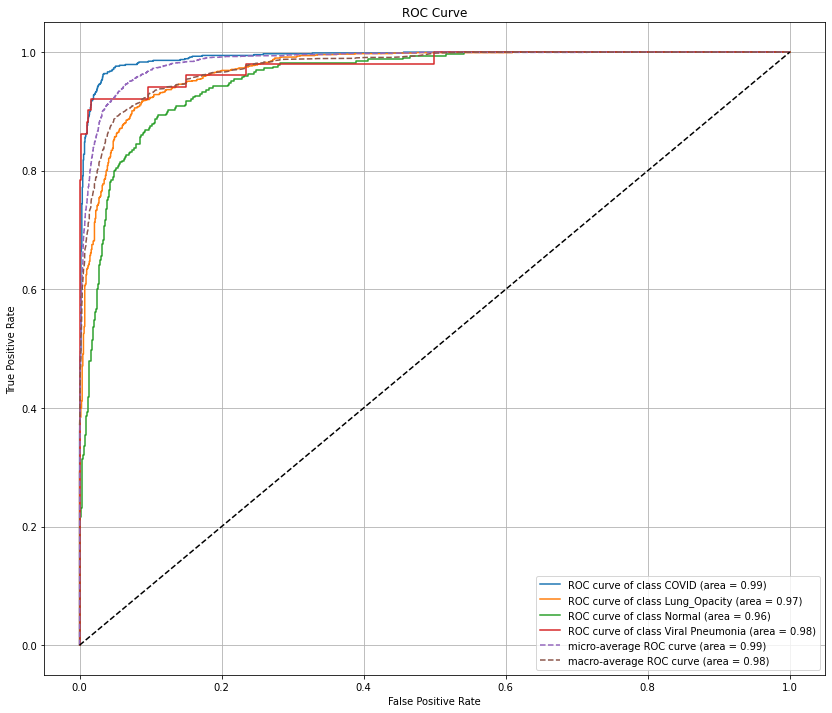

In [24]:
# ROC Curve for model loaded with weights from checkpoint
print('Classwise ROC Curve for ResNet Model :-')
ROC_Curve(y_test, new_prob_pred_resnet)

# As we can see here that model with weights from epoch with hightes val_accuracy is performing 
# better than model with weights at final epoch.